<h1>Flickbike Data-Analyse  <p style="color:gray;display:inline;font-size:14px;">  Schiphol-Oost</p></h1>

<hr style="height:2px;border-width:0;color:gray;background-color:gray"> 
<img src='img/schiphol.jpg?raw=true' style=width:100%>
<hr style="height:2px;border-width:0;color:gray;background-color:gray"> 

## De volgende onderzoeksvragen worden in dit notebook behandeld:

1. Welk model kan het beste dienen als voorspellend model van de groei van FlickBike? Wat zijn daarbij de invloeden van:
    1. Het weer. 
    2. De dag van de week. 
    3. Bijzondere dagen in het jaar, zoals feestdagen, schoolvakanties, etc. 
    4. Eventueel andere factoren. 
<br>
2. Wat is de beste strategie om fietsen te herdistribueren voor FlickBike? Kan, op basis van data, worden voorspeld waar er tekorten van fietsen dreigen te ontstaan en hoe de fietsen het beste zo kunnen worden verplaatst dat ze zowel over het hele terrein van Schiphol-Oost beschikbaar zijn en tegelijkertijd vooral beschikbaar zijn op plaatsen waar het regelmatig druk is? 
<br>
3. Met hoeveel fietsen zou FlickBike minimaal kunnen werken, zodanig dat te verwachten pieken op te vangen zijn?

<hr style="height:2px;border-width:0;color:gray;background-color:gray">

## Inhoudsopgave


1. [Inladen data en eerste exploratie](#Inladen-data-en-eerste-exploratie)
    1. [Imports](#Imports)
    2. [Inlezen bike data](#Inlezen-bike-data)
    3. [Grouperen en optellen op dag](#Grouperen-op-dag-en-optellen-voor-totaal-aantal-verhuurd-per-dag)
    4. [Aantal verhuurde fietsen in kaart brengen](#Aantal-verhuurde-fietsen-in-kaart-brengen)
    5. [Periodiciteit](#Periodiciteit)
2. [Invloed van het weer]()
    1. [(al)weer data ophalen en samenvoegen]()
    2. [KNMI api data  dictionary]()
    3. [Weerdata lijngrafiek]()
    4. [Correlatie matrix]()
3. [Invloed van de dag van de week]()
    1. [Scatterplot weekdag en aantal verhuurde fietsen]()
    2. [Vakantiedagen in kaart brengen en samenvoegen]()
4. [HetSmerigeModel™](#HetSmerigeModel™)
5. [Wat is de beste strategie om fietsen te herdistribueren voor FlickBike?]()
    1. [Ritten zonder verplaatsing filteren](#Ritten-zonder-verplaatsing-filteren)
    2. [Scatterplot met begin/eind locaties](#Scatterplot-met-begin/eind-locaties)
    3. [Opzetten KNeighbours](#Opzetten-KNeighbours)
    4. [In kaart brengen van fietsentekorten met KNeighbours](#In-kaart-brengen-van-fietsentekorten-met-KNeighbours)
    5. [Interactieve kaart bezetting Schiphol-Oost](#Interactieve-kaart-bezetting-Schiphol-Oost)
6. [Wat is de beste strategie om fietsen te herdistribueren voor FlickBike?]()
    1. [In kaart brengen wanneer fietsen in gebruik zijn](#In-kaart-brengen-wanneer-fietsen-in-gebruik-zijn)

# Inladen data en eerste exploratie
## Imports

In [126]:
from knmi_api import knmi_api

from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib

import seaborn as sns
import pandas as pd
import numpy as np
import mplleaflet

from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsClassifier

from IPython.display import clear_output
import datetime

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set()

## Inlezen bike data

In [2]:
df = pd.read_csv('../data/bikes.csv', index_col=0)
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
df.head()

,tripid,userid,bikeid,account,bikenumber,start_time,end_time,start_lat,start_lng,end_lat,end_lng,date
1,33838,13452,382,AR,6631000433,2019-01-01 06:46:03,2019-01-01 06:46:03,52.296065,4.787667,52.296200,4.787679,2019-01-01 06:46:00
2,33839,13452,812,AR,6631000146,2019-01-01 06:47:39,2019-01-01 06:47:39,52.295938,4.788336,52.295940,4.788557,2019-01-01 06:47:35
3,33851,13182,238,AR,6631000443,2019-01-01 14:15:36,2019-01-01 14:15:36,52.307337,4.807633,52.307336,4.807630,2019-01-01 14:15:32
4,33852,13182,238,AR,6631000443,2019-01-01 14:33:50,2019-01-01 14:33:50,52.308478,4.809970,52.308537,4.810099,2019-01-01 14:33:46
5,33867,12674,787,AG,6631000283,2019-01-01 20:11:05,2019-01-01 20:11:05,52.506522,4.727323,52.506809,4.732135,2019-01-01 20:11:01


## Grouperen op dag en optellen voor totaal aantal verhuurd per dag
Ook een kolom met dag, maand en weekdag worden toegevoegd

In [3]:
day_count = df.date.groupby(df.date.dt.floor('d')).count()
df_day = pd.DataFrame([day_count.index,day_count.values]).T
df_day.columns = ['date', 'count']
df_day.date = pd.to_datetime(df_day.date)
df_day['month'] = df_day.date.dt.month.astype('category')
df_day['weekday'] = df_day.date.dt.weekday.astype('category')
df_day['day'] = df_day.date.dt.dayofyear.astype('int')
df_day['count'] = df_day['count'].astype('int')
df_day.count = df_day['count'].astype('int')
print(df_day.dtypes)
df_day

date       datetime64[ns]
count               int32
month            category
weekday          category
day                 int32
dtype: object


,date,count,month,weekday,day
0,2019-01-01,8,1,1,1
1,2019-01-02,61,1,2,2
2,2019-01-03,90,1,3,3
3,2019-01-04,64,1,4,4
4,2019-01-05,17,1,5,5
...,...,...,...,...,...
337,2019-12-05,310,12,3,339
338,2019-12-06,203,12,4,340
339,2019-12-07,14,12,5,341
340,2019-12-08,19,12,6,342


## Aantal verhuurde fietsen in kaart brengen
Hier valt op dat er een continue groei plaatsvind.<br>

Text(0.5, 1.0, 'Aantal fietsen verhuurd per dag')

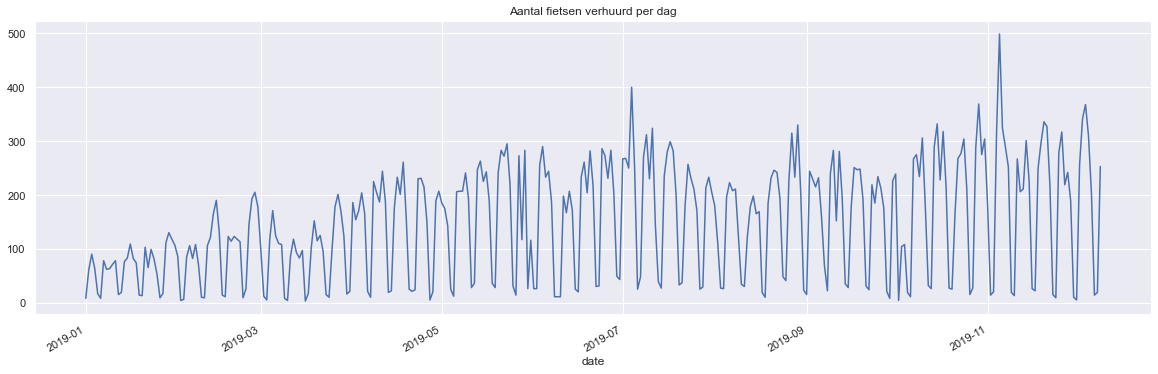

In [4]:
day_count.plot(figsize=[20,6])
plt.title("Aantal fietsen verhuurd per dag")

## Periodiciteit
Er blijkt een seizoensgebonden effect te zijn als we kijken naar de periodiciteit van de data

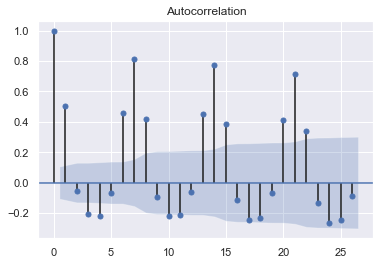

In [5]:
plot_acf(day_count)
pass

# Wat is de invloed van het weer op het aantal verkochte fietsen
## (al)weer data ophalen en samenvoegen
Hier wordt gebruik gemaakt van de [KNMI api](https://www.knmi.nl/kennis-en-datacentrum/achtergrond/data-ophalen-vanuit-een-script).<br>De opgevraagde data wordt vervolgens samengevoegd met de telling per dag dataframe.
#### KNMI api data dictionary:
- FG	Etmaalgemiddelde windsnelheid (in 0.1 m/s)
- FHX	Hoogste uurgemiddelde windsnelheid (in 0.1 m/s)
- FHXH	Uurvak waarin FHX is gemeten
- FHN	Laagste uurgemiddelde windsnelheid (in 0.1 m/s)
- FHNH	Uurvak waarin FHN is gemeten
- FXX	Hoogste windstoot (in 0.1 m/s)
- FXXH	Uurvak waarin FXX is gemeten
- TG	Etmaalgemiddelde temperatuur (in 0.1 graden Celsius)
- TN	Minimum temperatuur (in 0.1 graden Celsius)
- TNH	Uurvak waarin TN is gemeten
- TX	Maximum temperatuur (in 0.1 graden Celsius)
- TXH	Uurvak waarin TX is gemeten
- T10N	Minimum temperatuur op 10 cm hoogte (in 0.1 graden Celsius)
- T10NH	6-uurs tijdvak waarin T10N is gemeten
- SQ	Zonneschijnduur (in 0.1 uur) berekend uit de globale straling (-1 voor <0.05 uur)
- SP	Percentage van de langst mogelijke zonneschijnduur
- Q	Globale straling (in J/cm2)
- DR	Duur van de neerslag (in 0.1 uur)
- RH	Etmaalsom van de neerslag (in 0.1 mm) (-1 voor <0.05 mm)
- RHX	Hoogste uursom van de neerslag (in 0.1 mm) (-1 voor <0.05 mm)
- RHXH	Uurvak waarin RHX is gemeten
- PG	Etmaalgemiddelde luchtdruk herleid tot zeeniveau (in 0.1 hPa) berekend uit 24 uurwaarden
- PX	Hoogste uurwaarde van de luchtdruk herleid tot zeeniveau (in 0.1 hPa)
- PXH	Uurvak waarin PX is gemeten
- PN	Laagste uurwaarde van de luchtdruk herleid tot zeeniveau (in 0.1 hPa)
- PNH	Uurvak waarin PN is gemeten
- VVN	Minimum opgetreden zicht
- VVNH	Uurvak waarin VVN is gemeten
- VVX	Maximum opgetreden zicht
- VVXH	Uurvak waarin VVX is gemeten
- NG	Etmaalgemiddelde bewolking (bedekkingsgraad van de bovenlucht in achtsten, 9=bovenlucht onzichtbaar)
- UG	Etmaalgemiddelde relatieve vochtigheid (in procenten)
- UX	Maximale relatieve vochtigheid (in procenten)
- UXH	Uurvak waarin UX is gemeten
- UN	Minimale relatieve vochtigheid (in procenten)
- UNH	Uurvak waarin UN is gemeten
- EV24	Referentiegewasverdamping (Makkink) (in 0.1 mm)

In [6]:
knmi_api.collect_weather(
    start='20190101',
    end='20191209',
    vars='TX:TG:SQ:DR:FG',
    filename='weather_data.txt'
)
weather_df = knmi_api.read_to_df('weather_data.txt')
wcols = weather_df.columns[1:]
weather_df[wcols] = weather_df[wcols].astype('int')
weather_df

,date,TX,TG,SQ,DR,FG
0,2019-01-01,91,77,13,23,76
1,2019-01-02,71,56,4,0,48
2,2019-01-03,68,31,46,0,23
3,2019-01-04,68,54,0,0,45
4,2019-01-05,81,72,0,6,65
...,...,...,...,...,...,...
338,2019-12-05,58,22,20,11,52
339,2019-12-06,100,73,0,95,98
340,2019-12-07,104,95,0,0,72
341,2019-12-08,114,93,24,45,104


In [7]:
df_day = df_day.join(weather_df.set_index('date'), on='date')
df_day

,date,count,month,weekday,day,TX,TG,SQ,DR,FG
0,2019-01-01,8,1,1,1,91,77,13,23,76
1,2019-01-02,61,1,2,2,71,56,4,0,48
2,2019-01-03,90,1,3,3,68,31,46,0,23
3,2019-01-04,64,1,4,4,68,54,0,0,45
4,2019-01-05,17,1,5,5,81,72,0,6,65
...,...,...,...,...,...,...,...,...,...,...
337,2019-12-05,310,12,3,339,58,22,20,11,52
338,2019-12-06,203,12,4,340,100,73,0,95,98
339,2019-12-07,14,12,5,341,104,95,0,0,72
340,2019-12-08,19,12,6,342,114,93,24,45,104


### Weerdata lijngrafiek
Dit is niet heel veel zeggend, maar we zien wel dat de data correct wordt uitgelezen.<br>
Ook lijkt er een correlatie te zijn tussen TX en TG en verhuurde fietsen

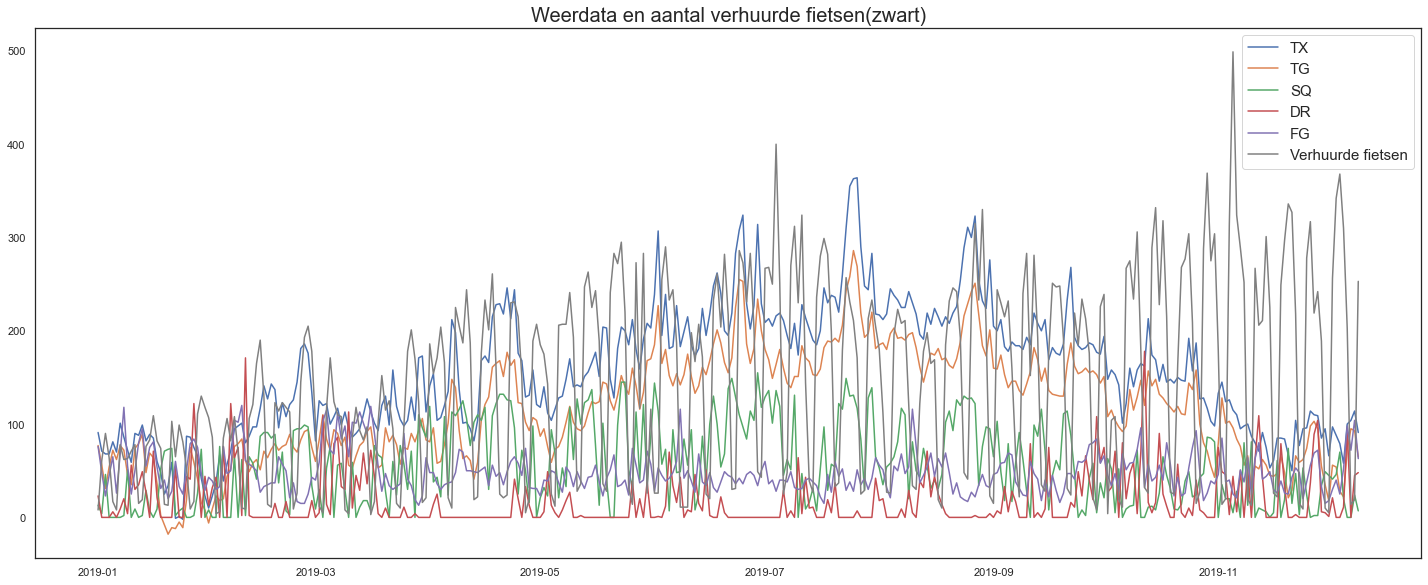

In [8]:
plt.figure(figsize=[20,8])
sns.set_style('white')
for col in weather_df[wcols]:
    plt.plot(weather_df.date, weather_df[col], label=col)
plt.plot(df_day.date, df_day['count'], label='Verhuurde fietsen', color='gray')
plt.tight_layout()
plt.title("Weerdata en aantal verhuurde fietsen(zwart)", fontsize=20)
plt.legend(fontsize=15)

### Correlatie matrix
<b>We zien dat het weer wel degelijk effect heeft op de fietsen.</b><br>
Mijn observatie van hierboven wordt bevestigd doordat er een duidelijke correlatie te zien valt tussen TX en TG.<br> Verder is opvallend dat FG een nog grotere negatieve correlatie heeft.<br>
Ook SQ en DR lijken licht gecorreleerd te zijn.

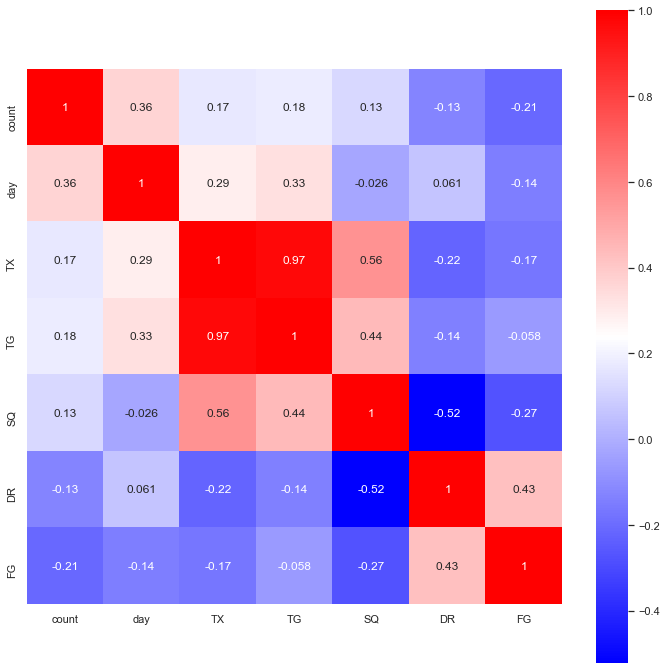

In [9]:
plt.figure(figsize=[12,12])
sns.heatmap(df_day.corr(), annot=True, square=True, cmap='bwr')

# Wat is de invloed van de dag van de week
## Scatterplot weekdag en aantal verhuurde fietsen
Een pienter oog merkt gelijk op dat de er een duidelijk verschil zit tussen de werkdagen en het weekend<br>
Ook valt op dat er een aantal werkdagen(5) niet wordt gewerkt. Dit duidt op vakantiedagen.

Text(0.5, 1.0, 'Aantal fietsen verhuurd per dag van de week')

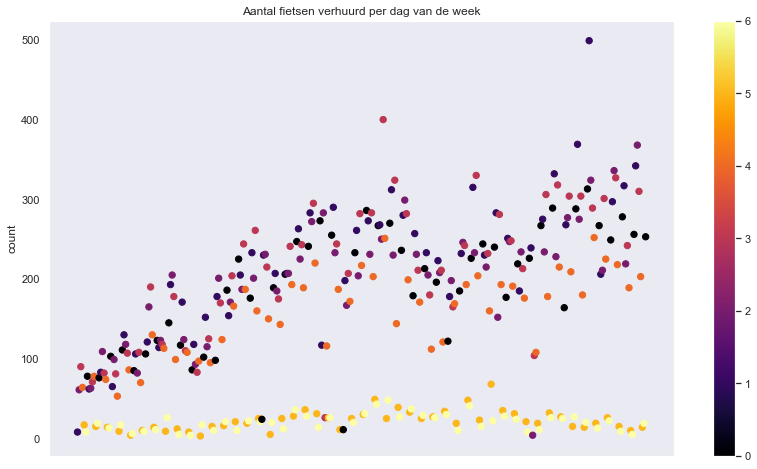

In [10]:
sns.set_style('dark')
df_day.plot.scatter('date','count', c=df_day.weekday, figsize=[14,8], cmap='inferno', s=40)
plt.title("Aantal fietsen verhuurd per dag van de week")

## Vakantiedagen in kaart brengen en samenvoegen
Er zijn 5 werkdagen die erg weinig verhuurde fietsen laten zien.<br>
Deze dagen worden toegevoegd als vakantiedagen

In [11]:
days_off = df_day.loc[(df_day.weekday != 5) & (df_day.weekday != 6) & (df_day['count'] <= 50)]
days_off.date = pd.to_datetime(days_off.date)
days_off

,date,count,month,weekday,day,TX,TG,SQ,DR,FG
0,2019-01-01,8,1,1,1,91,77,13,23,76
111,2019-04-22,24,4,0,112,246,177,126,0,49
149,2019-05-30,26,5,3,150,208,168,36,38,71
159,2019-06-10,11,6,0,161,215,175,56,8,50
273,2019-10-02,4,10,2,275,148,108,63,27,45


In [12]:
df_day['holiday'] = False
for x in days_off.index:
    df_day.holiday.loc[x] = True
    
df_day

,date,count,month,weekday,day,TX,TG,SQ,DR,FG,holiday
0,2019-01-01,8,1,1,1,91,77,13,23,76,True
1,2019-01-02,61,1,2,2,71,56,4,0,48,False
2,2019-01-03,90,1,3,3,68,31,46,0,23,False
3,2019-01-04,64,1,4,4,68,54,0,0,45,False
4,2019-01-05,17,1,5,5,81,72,0,6,65,False
...,...,...,...,...,...,...,...,...,...,...,...
337,2019-12-05,310,12,3,339,58,22,20,11,52,False
338,2019-12-06,203,12,4,340,100,73,0,95,98,False
339,2019-12-07,14,12,5,341,104,95,0,0,72,False
340,2019-12-08,19,12,6,342,114,93,24,45,104,False


# HetSmerigeModel™

MSE: 150.7757403508772


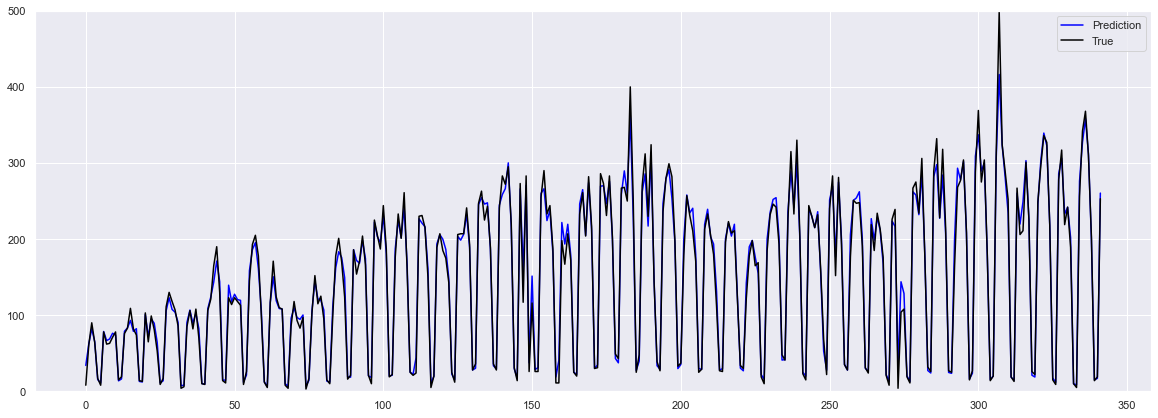

In [13]:
X = df_day[['day','weekday','holiday', 'TX','TG','SQ','DR','FG']]
y = df_day['count']

slice_size = 0
if slice_size:
    X_train, y_train = X[:slice_size], y[:slice_size]
    X_test, y_test = X[slice_size:], y[slice_size:]
else:
    X_train, y_train = X, y
    X_test, y_test = X, y  

reg = RandomForestRegressor(random_state=42)
# reg = LinearRegression()
# reg = MLPRegressor(max_iter=1000, hidden_layer_sizes=(50,5))
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

print("MSE:",mean_squared_error(y_test, y_pred))

plt.figure(figsize=[20,7])
sns.set_style('darkgrid')
plt.plot(X_test.index, y_pred, label='Prediction', color='blue')
plt.plot(X.index, y, label='True', color='black')
plt.ylim([0,500])
plt.legend()

In [14]:
knmi_api.collect_weather(
    start='20191101',
    end='20200131',
    vars='TX:TG:SQ:DR:FG',
    filename='weather_data_submission.txt'
)
X_sub = knmi_api.read_to_df('weather_data_submission.txt')
wcols = X_sub.columns[1:]
X_sub[wcols] = X_sub[wcols].astype('int')
X_sub['weekday'] = X_sub['date'].dt.weekday.astype('category')
X_sub['month'] = X_sub['date'].dt.month.astype('category')
X_sub['day'] = 253 + X_sub['date'].dt.day.astype('int')
X_sub['holiday'] = 0
mask = (X_sub['date'] > '2019-12-21') & (X_sub['date'] <= '2020-01-05')
X_sub['holiday'] = mask
X_sub

,date,TX,TG,SQ,DR,FG,weekday,month,day,holiday
0,2019-11-01,133,79,0,75,46,4,11,254,False
1,2019-11-02,145,128,35,49,85,5,11,255,False
2,2019-11-03,124,101,20,46,38,6,11,256,False
3,2019-11-04,126,103,20,3,40,0,11,257,False
4,2019-11-05,115,96,5,44,25,1,11,258,False
...,...,...,...,...,...,...,...,...,...,...
87,2020-01-27,92,80,0,60,62,0,1,280,False
88,2020-01-28,70,57,21,46,89,1,1,281,False
89,2020-01-29,80,63,8,13,85,2,1,282,False
90,2020-01-30,115,88,19,31,85,3,1,283,False


In [15]:
X_sub.dtypes

date       datetime64[ns]
TX                  int32
TG                  int32
SQ                  int32
DR                  int32
FG                  int32
weekday          category
month            category
day                 int32
holiday              bool
dtype: object

In [16]:
true_score = df_day[['date','count']]
true_score.columns = ['id', 'Predicted']
true_score['id'] = true_score['id'].dt.strftime('%Y%m%d')
true_score = true_score.set_index('id')
true_score.to_csv('true_score.csv')
true_score

,Predicted
id,
20190101,8
20190102,61
20190103,90
20190104,64
20190105,17
...,...
20191205,310
20191206,203
20191207,14


In [17]:
y_sub = reg.predict(X_sub[['day','weekday','holiday', 'TX','TG','SQ','DR','FG']])

submission_df = pd.DataFrame(pd.date_range(start='20191101', end='20200131'), columns=['id'])
submission_df['id'] = submission_df['id'].dt.strftime('%Y%m%d')
submission_df['Predicted'] = y_sub
submission_df = submission_df.set_index('id')
submission_df

,Predicted
id,
20191101,145.13
20191102,14.96
20191103,18.56
20191104,245.05
20191105,205.40
...,...
20200127,238.33
20200128,241.08
20200129,262.60


In [18]:
# submission_final = pd.concat([submission_df, true_score])
submission_final = submission_df
# submission_final

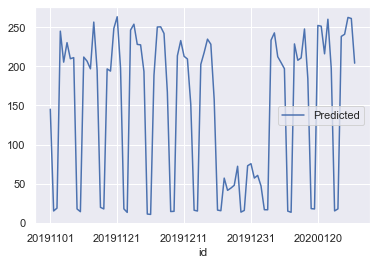

In [19]:
submission_final.to_csv('submission.csv')
submission_final.plot()

In eerste instantie hebben wij een random forest classifier gebruikt. Die presteerde aanzienlijk minder. Wij denken dat dat komt omdat de groei daar minder werd in meegenomen. Nu gebruiken wij lineaire regressie wij zien hier dat het resultaat beter is. Misschien telt ook mee dat de factoren bij lineaire regressie veel meer op een geleidelijke schaal worden meegenomen. Zo kan het dat het niet goed werkt om te zeggen dat als de temperatuur hoger is dan x dat gebruik dan in regio y tot z zal zitten. Maar dat dit een veel geleidelijkere schaal is. 
Ook merken wij op dat ons model de groei niet heel goed inschat. Wij lijden dit af uit het feit dat het gebruik aan het begin erg wordt overschat en aan het eind wordt onderschat. Ook kan je opmaken dat als je een trendlijn tekent op de grafiek die van de voorspelling minder stijl loopt dan die van de daadwerkelijke waarden.

Hoe nu veder.

•	Wij willen de maand en dag categoriaal indelen. Hierdoor wordt het voor het model en specifiek voor een lineaire regressie model makkelijker om  de invloed van deze variabelen in te schatten.

•	Veder willen wij de vakantie periode meenemen. Dit willen wij later misschien nog uitbreiden met hoeveel mensen procentueel vrij nemen in een bepaalde week van de vakantie.

•	Ook zien wij een aantal uitschieters in de data. Wij willen onderzoeken op welke dagen deze uitschieters plaatsvinden en kijken of zij een gemeen schappelijke eigenschap hebben.


# Wat is de beste strategie om fietsen te herdistribueren voor FlickBike? 
## Ritten zonder verplaatsing filteren
Er zijn klaarblijkelijk 8840 fietsritten met zowel de zelfde start- als eindcoorindaten 

In [20]:
print("Aantal ritten met zowel zelfde start als eindcoordinaten:",
      len(df[df.start_lat==df.end_lat][df.start_lng==df.end_lng]))

Aantal ritten met zowel zelfde start als eindcoordinaten: 8840


In [21]:
df = df[df.start_lat!=df.end_lat][df.start_lng!=df.end_lng]

## Scatterplot met begin/eind locaties
Hier is meer onderzoek nodig. Dit is niet erg veelzeggend..

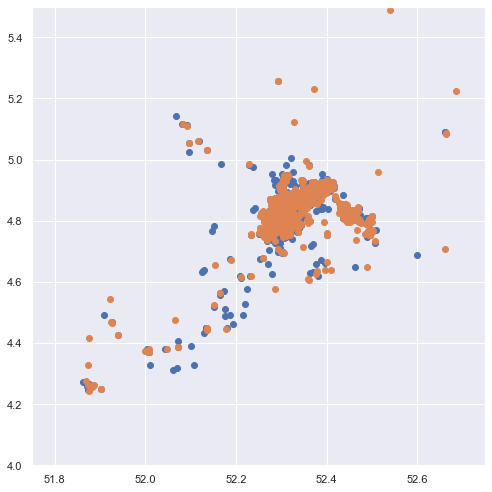

In [22]:
plt.figure(figsize=[7,7])
plt.scatter(df.start_lat, df.start_lng)
plt.scatter(df.end_lat, df.end_lng)
plt.xlim([51.75,52.75])
plt.ylim([4,5.5])
plt.tight_layout()

In [23]:
df.head()

,tripid,userid,bikeid,account,bikenumber,start_time,end_time,start_lat,start_lng,end_lat,end_lng,date
1,33838,13452,382,AR,6631000433,2019-01-01 06:46:03,2019-01-01 06:46:03,52.296065,4.787667,52.296200,4.787679,2019-01-01 06:46:00
2,33839,13452,812,AR,6631000146,2019-01-01 06:47:39,2019-01-01 06:47:39,52.295938,4.788336,52.295940,4.788557,2019-01-01 06:47:35
3,33851,13182,238,AR,6631000443,2019-01-01 14:15:36,2019-01-01 14:15:36,52.307337,4.807633,52.307336,4.807630,2019-01-01 14:15:32
4,33852,13182,238,AR,6631000443,2019-01-01 14:33:50,2019-01-01 14:33:50,52.308478,4.809970,52.308537,4.810099,2019-01-01 14:33:46
5,33867,12674,787,AG,6631000283,2019-01-01 20:11:05,2019-01-01 20:11:05,52.506522,4.727323,52.506809,4.732135,2019-01-01 20:11:01


## Opzetten KNeighbours
Er wordt een tabel aangemaakt met daarop alle start- en eindcoordinaten met een label start of niet

In [24]:
df_start = df[['start_lat','start_lng','start_time']]
df_start.columns = ['lat','lng','timestamp']
df_start['is_start'] = True

df_end = df[['end_lat','end_lng', 'end_time']]
df_end.columns = ['lat','lng','timestamp']
df_end['is_start'] = False

df_coords = pd.concat([df_start,df_end])
df_coords

,lat,lng,timestamp,is_start
1,52.296065,4.787667,2019-01-01 06:46:03,True
2,52.295938,4.788336,2019-01-01 06:47:39,True
3,52.307337,4.807633,2019-01-01 14:15:36,True
4,52.308478,4.809970,2019-01-01 14:33:50,True
5,52.506522,4.727323,2019-01-01 20:11:05,True
...,...,...,...,...
50372,52.307692,4.806554,2019-12-09 22:48:19,False
50373,52.307746,4.806697,2019-12-09 22:48:14,False
50375,52.307642,4.800440,2019-12-09 23:15:33,False
50376,52.307784,4.807289,2019-12-10 09:27:59,False


In [25]:
X = df_coords[['lat','lng']]
y = df_coords['is_start']

In [26]:
n = 25
clf = KNeighborsClassifier(n_neighbors=n, n_jobs=2, weights='distance')
clf.fit(X, y)

KNeighborsClassifier(n_jobs=2, n_neighbors=25, weights='distance')

In [27]:
def heatmap(area,df_coords,resolution=.0005, scatter=False, samples=0):
    X = df_coords[['lat','lng']]
    y = df_coords['is_start']
    x_min, x_max, y_min, y_max = area
    # Grid size
    h = resolution

    # Meshgrid init
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h))

    # Colormap
    cmap_bold = ListedColormap(['lightgray', 'yellow'])
    cmap_light = ListedColormap(['black', 'orange'])

    # predict class using data and kNN classifier
    Z = clf.predict(np.c_[yy.ravel(), xx.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=[10,10])
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    
    if scatter:
        if samples:
            s = df_coords.sample(samples)
            X = s[['lat','lng']]
            y = s['is_start']

        plt.scatter(X.lng, X.lat, c=y, cmap=cmap_bold, s=2)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
    return fig

In [28]:
schiphol_large_area = [4.725,4.9,52.25,52.35]
schiphol_smaller_area = [4.77,4.83,52.28,52.34]
schiphol_east = [4.78,4.815,52.29,52.315]

entire_database = [df_coords.lng.min(),df_coords.lng.max(),df_coords.lat.min(),df_coords.lat.max()]

## In kaart brengen van fietsentekorten met KNeighbours
<hr style="height:2px;border-width:0;color:gray;background-color:gray">

![](img/bike_project.jpg)

Schiphol en omgeving (groot)
Schiphol en omgeving (klein)
Schiphol-Oost


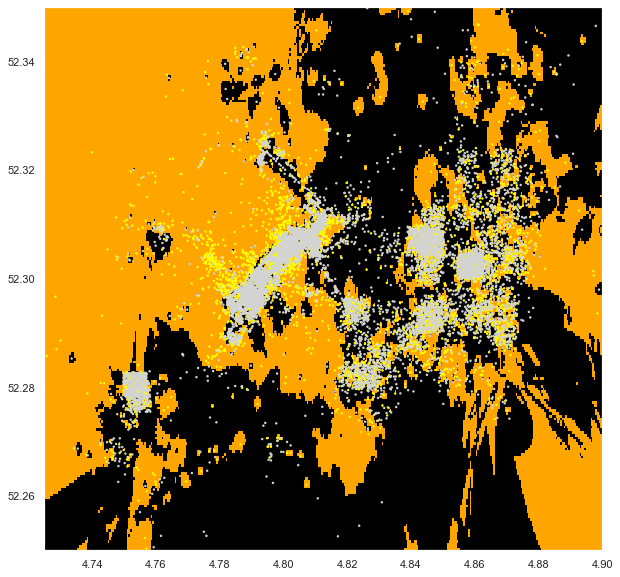

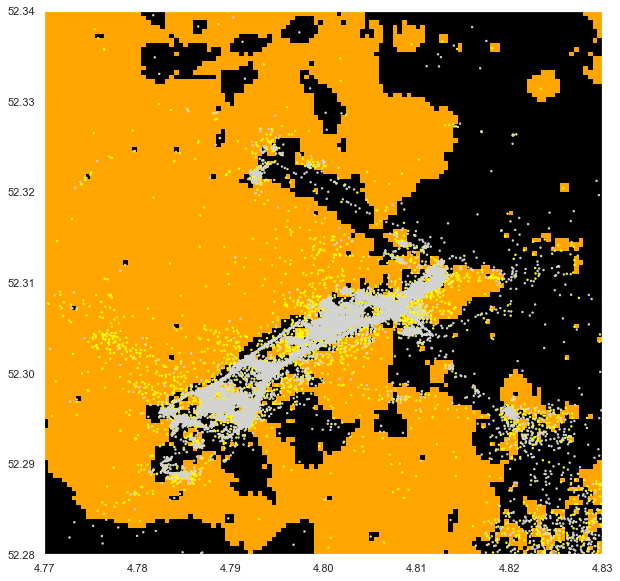

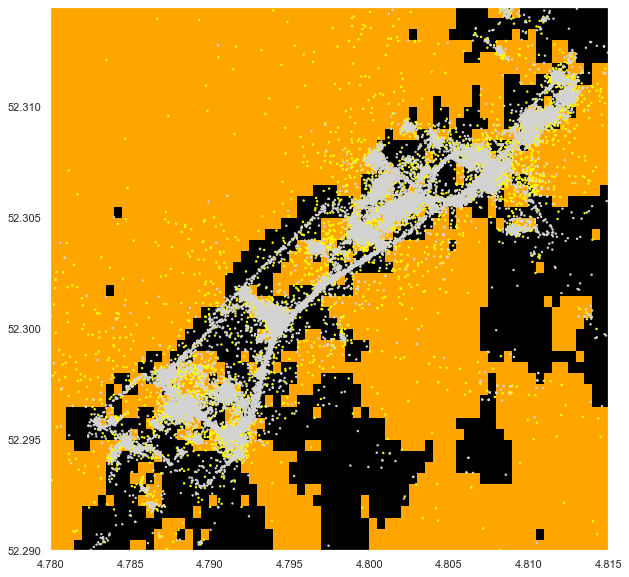

In [29]:
print("Schiphol en omgeving (groot)")
heatmap(schiphol_large_area,df_coords, scatter=True)
print("Schiphol en omgeving (klein)")
heatmap(schiphol_smaller_area,df_coords, scatter=True)
print("Schiphol-Oost")
heatmap(schiphol_east,df_coords, scatter=True)
pass

## Interactieve kaart bezetting Schiphol-Oost
Het is mogelijk om de resolutie te verkleinen om zo een algemener beeld te krijgen

In [30]:
fig=heatmap(schiphol_east,df_coords, resolution=.003)
mplleaflet.display(fig=fig)

In [31]:
df_coords

,lat,lng,timestamp,is_start
1,52.296065,4.787667,2019-01-01 06:46:03,True
2,52.295938,4.788336,2019-01-01 06:47:39,True
3,52.307337,4.807633,2019-01-01 14:15:36,True
4,52.308478,4.809970,2019-01-01 14:33:50,True
5,52.506522,4.727323,2019-01-01 20:11:05,True
...,...,...,...,...
50372,52.307692,4.806554,2019-12-09 22:48:19,False
50373,52.307746,4.806697,2019-12-09 22:48:14,False
50375,52.307642,4.800440,2019-12-09 23:15:33,False
50376,52.307784,4.807289,2019-12-10 09:27:59,False


## Omgeving verdelen in vierkante hokjes en het fiets overschot/tekort weergeven
Hieronder verdeel ik de omgeving in squares en plot ik met een heatmap het overschot/tekort

In [300]:
def heatmap(df, area, resolution, lim=(None,None), timeframe=None):
    test_df = df
    test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
    if timeframe != None:
        start_date, end_date = timeframe
        mask = (test_df['timestamp'] >= start_date) & (test_df['timestamp'] <= end_date)
        tmp_df = test_df.loc[mask]
        title = "Heatmap " + str(timeframe[0] + "-" + str(timeframe[1]))
    else:
        tmp_df = test_df
        title = "Heatmap (Gehele dataset)"

    min_lat, max_lat = area[2], area[3]
    min_lng, max_lng = area[0], area[1]
    scope_lat = abs(min_lat - max_lat) / resolution
    scope_lng = abs(min_lng - max_lng) / resolution
    squares = np.zeros([resolution,resolution])
    
    tmp_df = tmp_df[tmp_df.lat>=min_lat]
    tmp_df = tmp_df[tmp_df.lat<=max_lat]
    tmp_df = tmp_df[tmp_df.lng>=min_lng]
    tmp_df = tmp_df[tmp_df.lng<=max_lng]
    total_datapoints = tmp_df.count()[0]
    
    ts = datetime.datetime.now()
    timelog = np.array([])
    for ix in range(resolution):
        delta = (datetime.datetime.now() - ts).microseconds/1000
        timelog = np.append(timelog, delta)
        ts = datetime.datetime.now()
        print("Total datapoints:",total_datapoints)
        print("Processing column: {}/{}".format(ix, resolution))
        print("Current compute time: {} ms".format(round(delta),1))
        print("Average compute time: {} ms".format(round(timelog.mean(),1)))
        clear_output(True)
        
        square_lat_min, square_lat_max = min_lat + scope_lat * ix, min_lat + scope_lat * (ix+1)
        for yx in range(resolution):
            square_lng_min, square_lng_max = min_lng + scope_lng * yx, min_lng + scope_lng * (yx+1)

            square_rides = tmp_df[(tmp_df.lat>=square_lat_min) & 
                                  (tmp_df.lat<=square_lat_max) & 
                                  (tmp_df.lng>=square_lng_min) & 
                                  (tmp_df.lng<=square_lng_max)]

            start_count  = square_rides[square_rides.is_start==True].count()[0]
            end_count = square_rides[square_rides.is_start==False].count()[0]

            diff = start_count - end_count
            squares[ix,yx] = diff


    xx, yy = np.meshgrid(np.arange(min_lat, max_lat, scope_lat),
    np.arange(min_lng, max_lng, scope_lng))
    fig = plt.figure(figsize=[12,9])
    f = plt.pcolormesh(yy, xx, squares, cmap='coolwarm', vmin=lim[0], vmax=lim[1])
    fig.colorbar(f)
    plt.title(title+" (lim={}/{})".format(lim[0], lim[1]))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

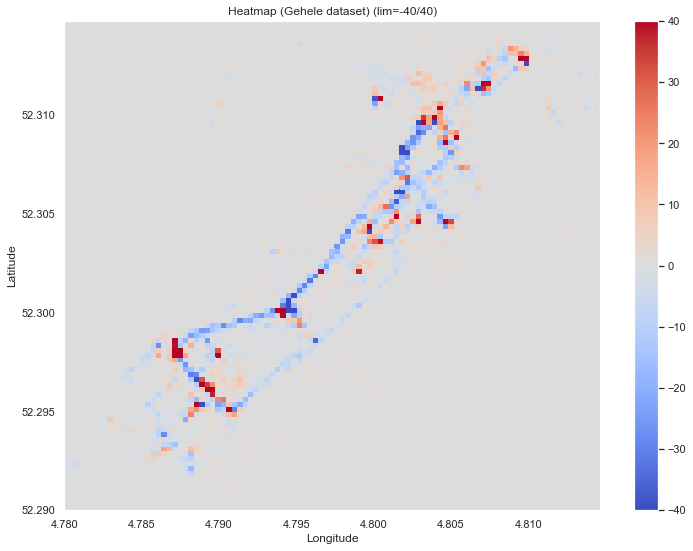

In [301]:
heatmap(
    df=df_coords, 
    area=schiphol_east, 
    resolution=100, 
    lim=(-40, 40),
    timeframe=None
)

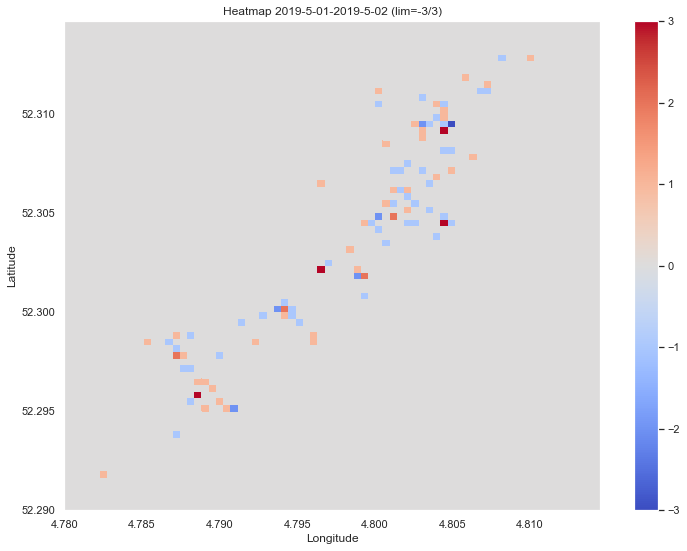

In [302]:
heatmap(
    df=df_coords, 
    area=schiphol_east, 
    resolution=75, 
    lim=(-3, 3),
    timeframe=('2019-5-01', '2019-5-02')
)

Hierboven wordt het overschot/tekort aan fietsen in hokjes weergegeven.

### Opvangen pieken


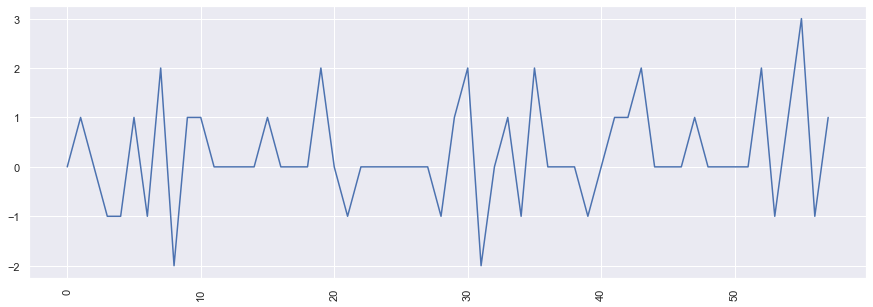

In [34]:
occupation_df = df_coords.copy()

target_date = '2019-03-05'
occupation_df['timestamp'] = pd.to_datetime(occupation_df['timestamp'])
occupation_df = occupation_df[occupation_df.timestamp.dt.date.astype('str') == target_date]

starts = occupation_df[occupation_df.is_start == True]
ends = occupation_df[occupation_df.is_start == False]

plus = starts.groupby(starts.timestamp.dt.floor('5T')).size().reset_index(name='plus')
minus = ends.groupby(ends.timestamp.dt.floor('5T')).size().reset_index(name='minus')

df_comb = pd.merge(plus, minus)
df_comb['diff'] = df_comb['plus'].astype('int') - df_comb['minus'].astype('int')
df_comb['time'] = df_comb['timestamp'].dt.time
# df_comb

plt.figure(figsize=[15,5])
plt.xticks(rotation=90)
plt.plot(df_comb['diff'])

#### In kaart brengen wanneer fietsen in gebruik zijn
Als wij willen weten met hoeveel fietsen flickbike minimaal kan werken dan moeten we natuurlijk weten wanneer elke fiets in gebruik is.

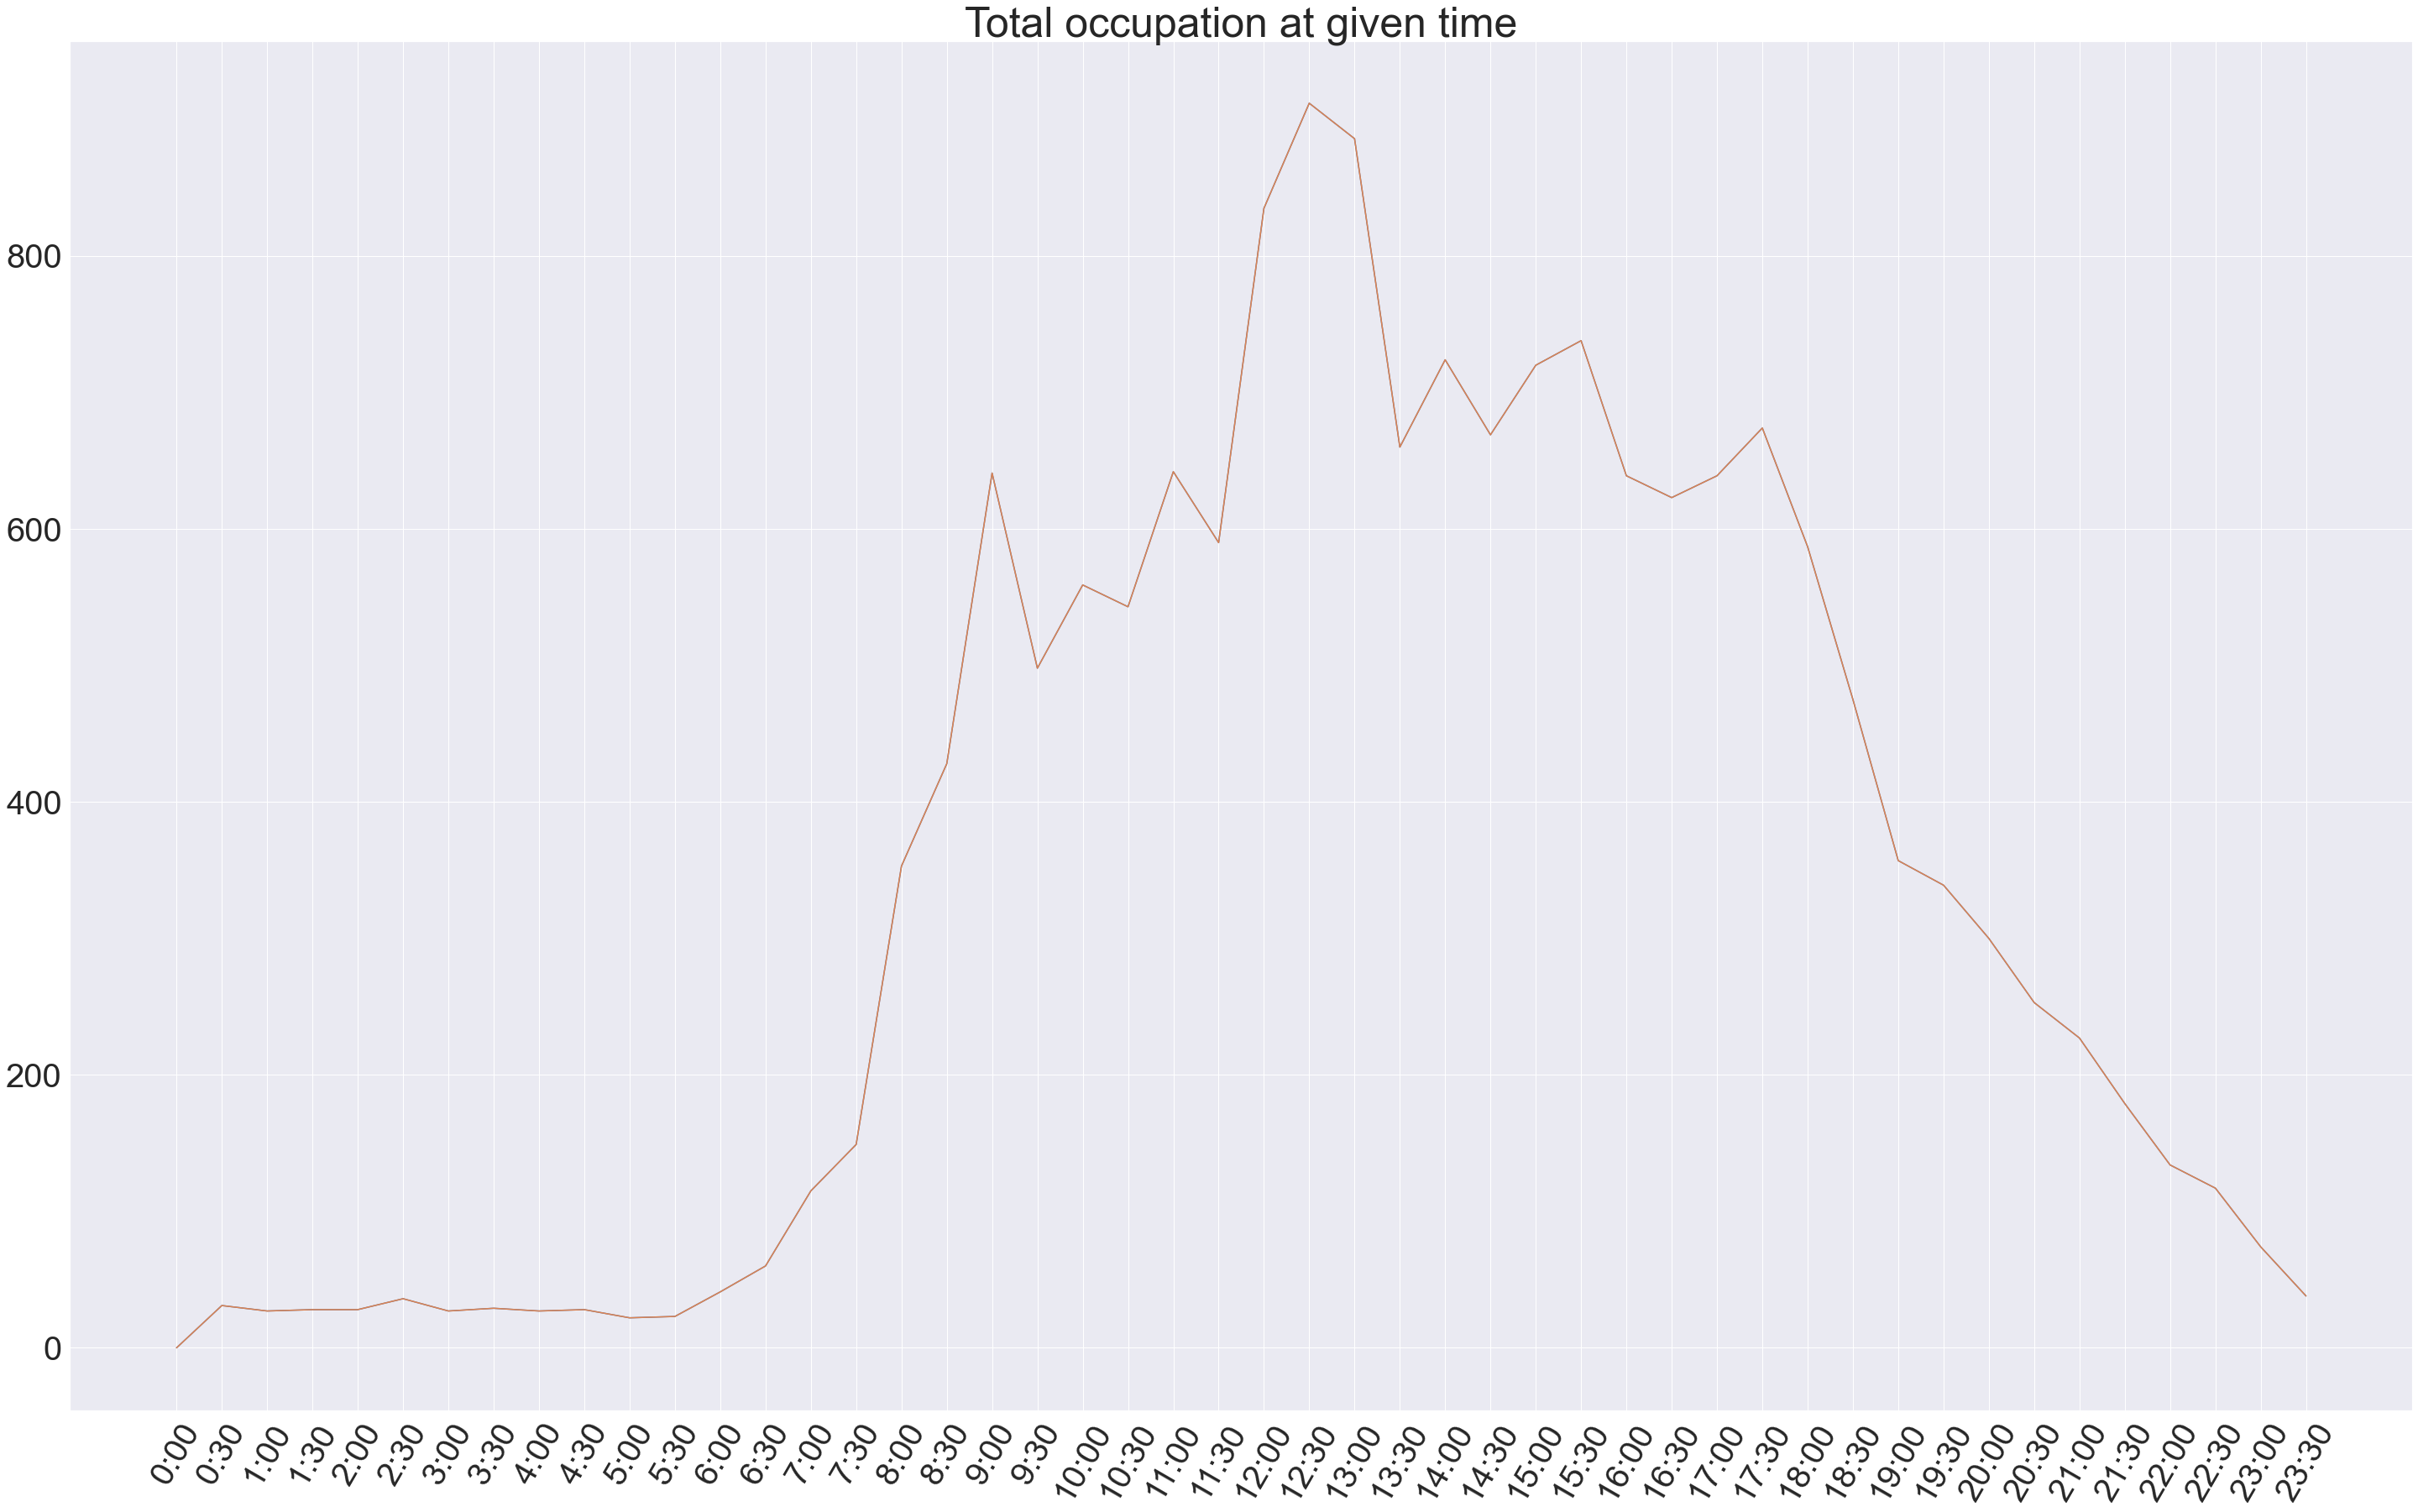

In [35]:
#Makes a copy of the dataframe so that we don't contaminate the original.
occupation_df = df.copy()

#Splits the date and the time into two different columns
occupation_df['start_date'] = pd.to_datetime(df['start_time']).dt.date
occupation_df['start_time'] = pd.to_datetime(df['start_time']).dt.time
occupation_df['end_date'] = pd.to_datetime(df['end_time']).dt.date
occupation_df['end_time'] = pd.to_datetime(df['end_time']).dt.time

#Generates a list of 30 minutes intervals starting at 0:00 ending at 23:30
lis = ['%s:%s' % (h, m) for h in ([0] + list(range(1,24))) for m in ('00', '30')]

#Checks for every time in the time list if that time is between the start and end time of a value in the dataset.
#Returns a serries with booleans representing if the time is between the start and endtime of the row.
#Right now they are all false because in the dataset the start time is equeal to the end time so no values can be inbetween them.
list_of_mask = []
for i in range(len(lis)):
    time = pd.to_datetime(lis[i], format='%H:%M').time()
    a = (time > occupation_df['start_time']) & (time < occupation_df['end_time'])
    list_of_mask.append(a)

#Plots the sum of all the bicycles that were occupied at a given time
oc_df = pd.concat(list_of_mask, axis=1)
oc_df.columns = lis
occupation_at_time = oc_df.sum()
occupation_at_time.plot()
occupation_at_time.plot(figsize=(50,30))
plt.xticks(range(0,len(occupation_at_time.index)), occupation_at_time.index)
plt.xticks(fontsize=40, rotation=60)
plt.yticks(fontsize=40)
plt.title("Total occupation at given time", fontsize=50)
plt.show()


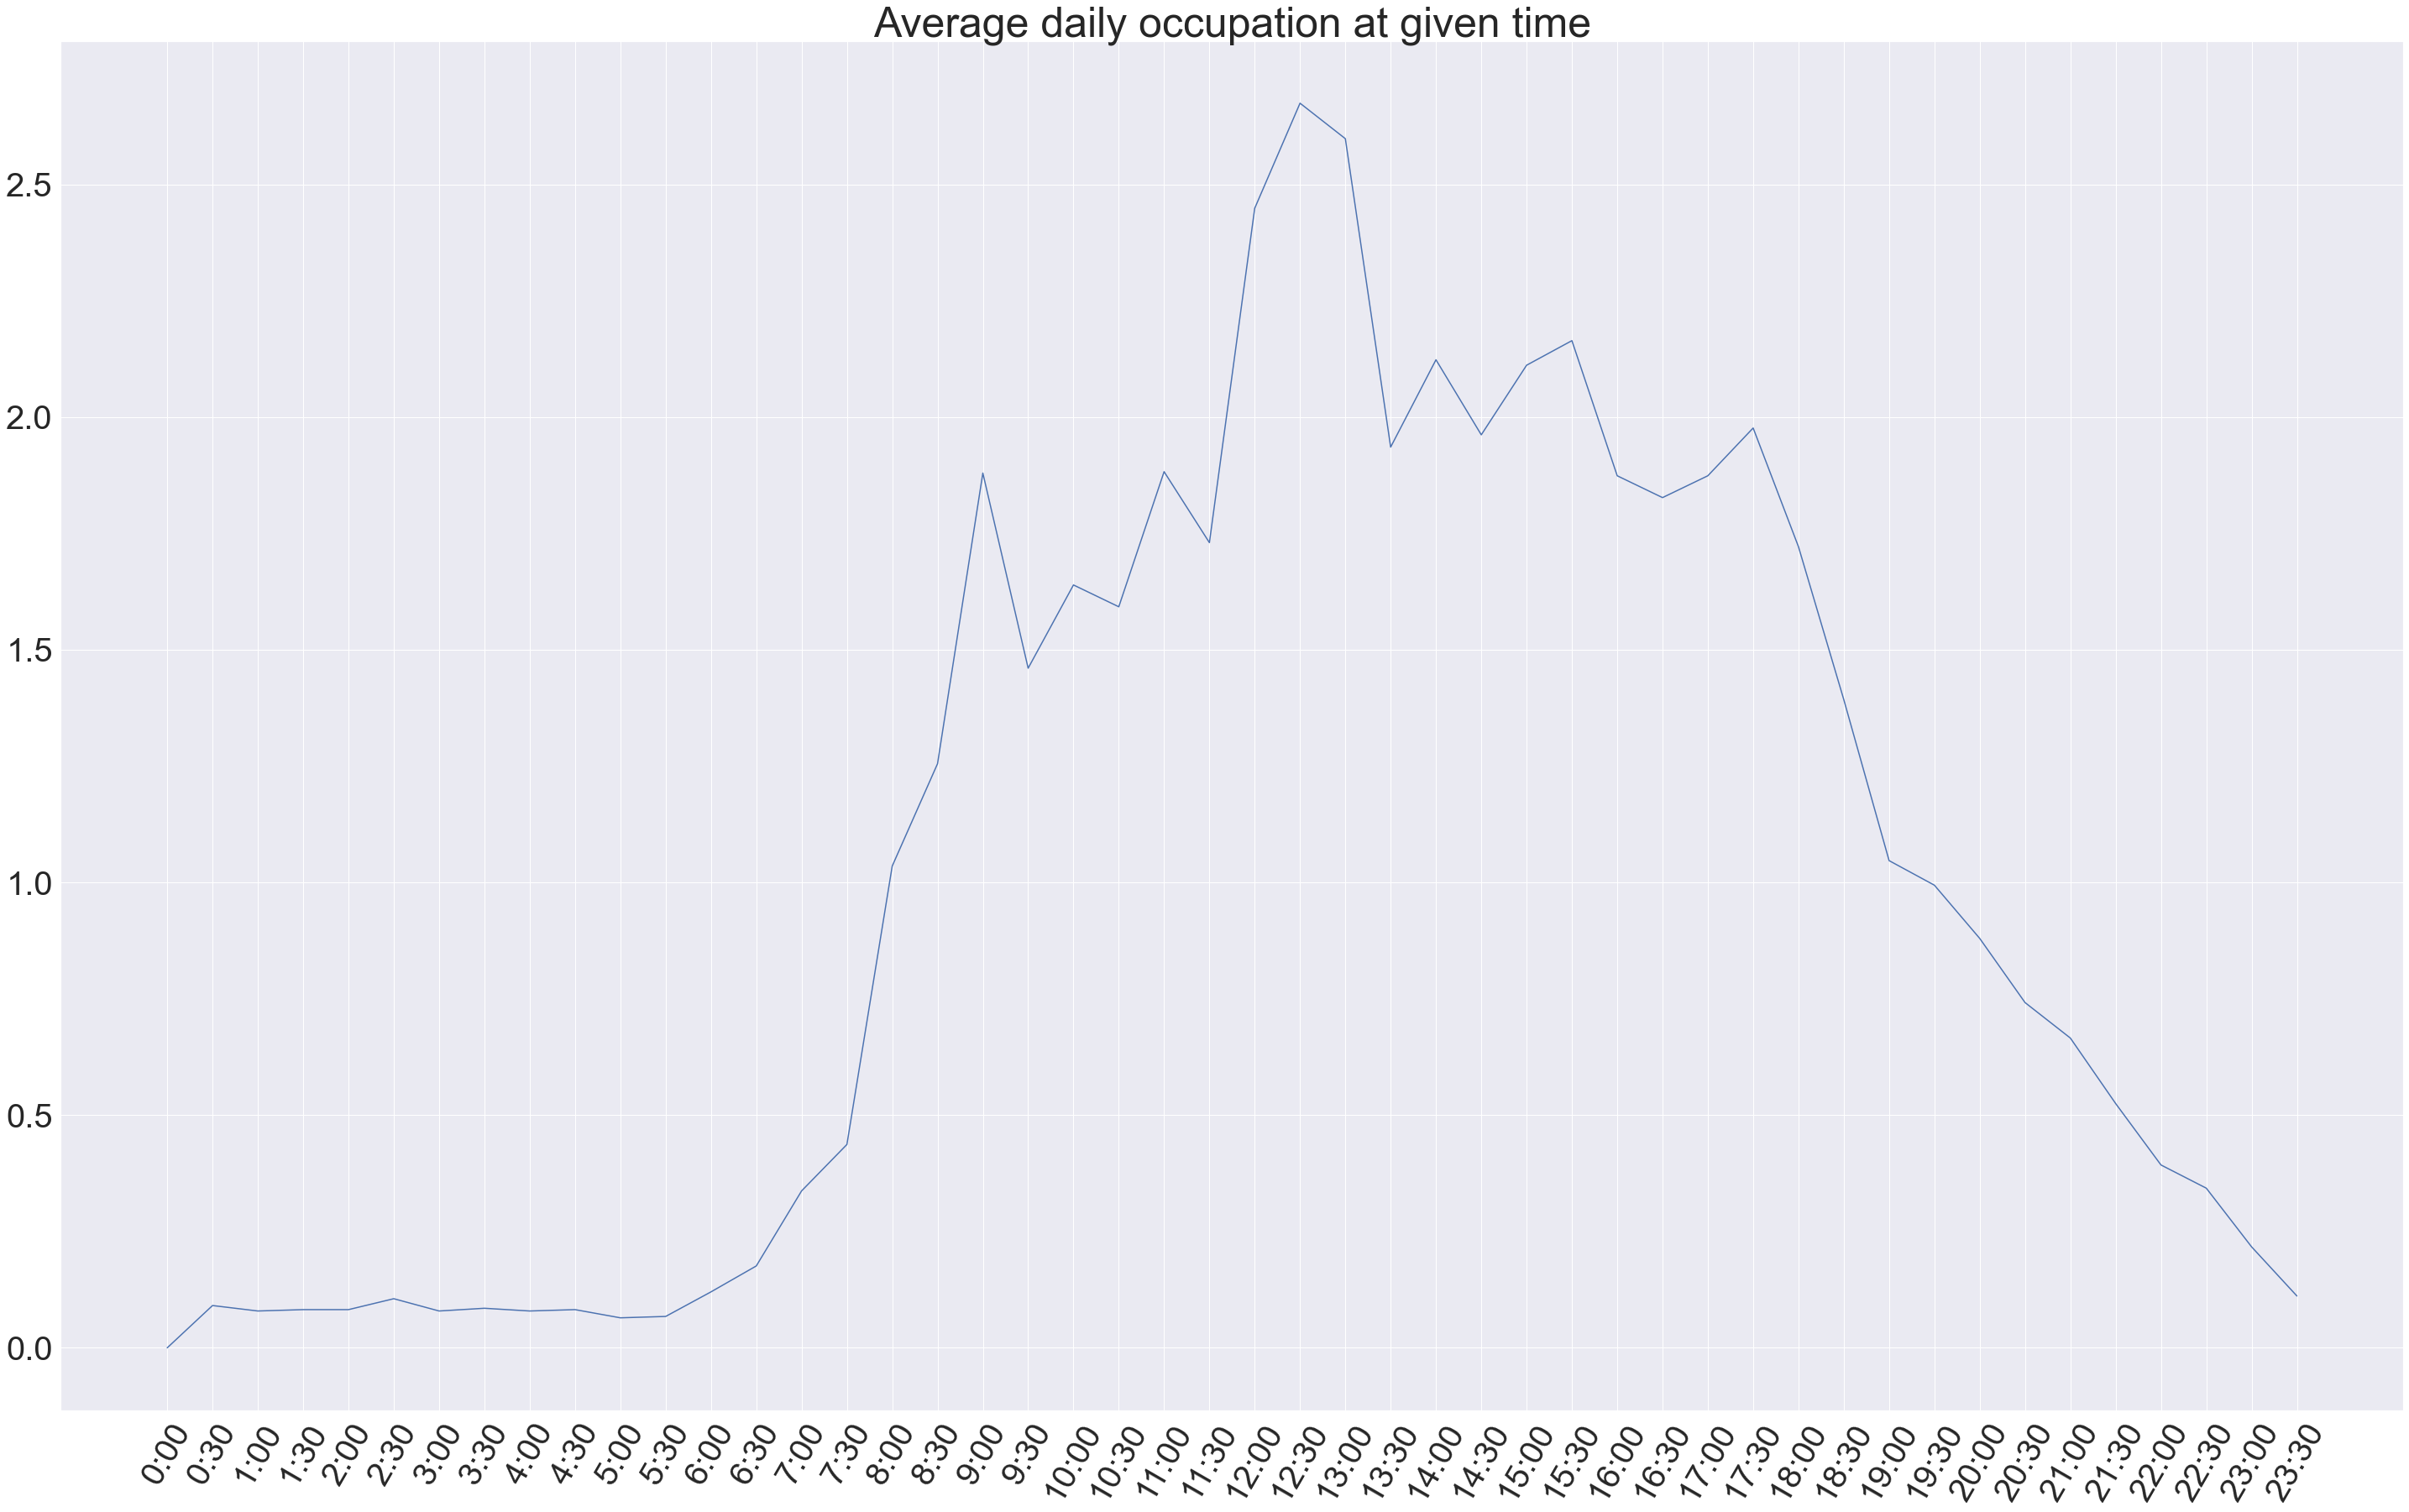

In [36]:
#Plots the sum of all the bicycles that where occupied during a single (average) day
dates_in_dataset = len(occupation_df["start_date"].unique())
a = oc_df.sum() / dates_in_dataset
a.plot(figsize=(50,30))
plt.xticks(range(0,len(a.index)), a.index)
plt.xticks(fontsize=40, rotation=60)
plt.yticks(fontsize=40)
plt.title("Average daily occupation at given time", fontsize=50)
plt.show()


### Hoe veder

Omdat de data niet helmaal klopt. (De start en end time zijn voor de meeste waarden het zelfde. Dit kan niet kloppen) kunnen wij hier niet mee verder. Als de data wel kloppend is kunnen we zien hoeveel fietsen in gebruik zijn bij de piek (12:30). Wij kunnen daarna kijken hoeveel effect de groei heeft op het gebruik tijdens de piek. Daarna kunnen we proberen te voorspellen hoeveel gebruik er zal zijn tijdens de piek in de toekomst. Als we die gegevens hebben weten we met hoeveel fietsen minimaal kan werken.

Wel moet dan nog worden geken welk effect een afnamen van de beschikbaren fietsen zal hebben op het gebruik. Het kan zo maar zijn dat er wel nog 10 fietsen beschikbaar zijn maar dat die heel ver weg zijn dus een gebruiker ervoor kiest om toch geen gebruik te maken van de fiets. Dit zijn dingen waar Flickbike rekening mee moet houden voordat ze hun beschikbaren fietsen gaan verminderen.